# Exercise 3 - CNNs, ResNets and LR-Scheduling

## General information
* Deep Learning – Summer Term 2022
* Instructor: Constantin Pape
* Due date: **Tuesday, 07. Jun 22, at 12:00** (due on Tuesday because Monday is a holiday)

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling
- [learn about transfer learning]

*We are looking forward to seeing your solutions! Have fun!*

### Important submission instructions

- **You need to answer all questions in written form!**
- When you're done, download the notebook and rename it to `<surname1>_<surname2>_<surname3>.ipynb`
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- Do not change the cells which are marked as "Do not change", similarly write your solution into the marked cells.

### Imports

In [169]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

## 1. Setup

You can use the functions to grab the data, split the sets and create the dataloaders, etc. given to you at exercise sheet 2.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Colab (which is recommended) you have to mount the drive first and create a path to your python module.

#### **TODO**
Create a file named 'utils.py' and import it here. You can import any package necessary.

In [170]:
# TODO import utils.py
from google.colab import drive
import sys
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/MyDrive')
from utils import *
import utils

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of 'utils.py' to instantiate the train-, test- and validation datasets along with their dataloaders.

In [171]:
# TODO define device
device = get_device()

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla T4


In [172]:
data_dir = 'data'
batch_size = 256

# TODO grab data, generate split, init data loaders
train,  test, dmean, dstd = grab_data("\ ")
train_set, val_set = generate_train_val_data_split(trainset=train, split_seed=42)

train_set, val_set, test_set = init_data_loaders(train_set, val_set, test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [173]:
# TODO define loss function
loss_function = torch.nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

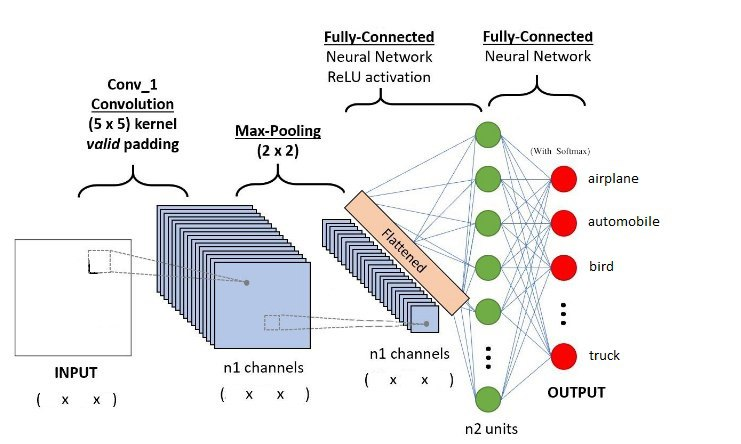

#### **Questions**

- What are the input dimensions? 
- What are the dimensions of the feature maps? 
- What are the dimensions after pooling? 
- What are the values for n1 and n2?
- What is the number of parameters for conv_1?

**Your answers here**
- input dimensions = (32 x 32 x 3)
- dimensions of the feature maps = (28 x 28 x 32)
- dimensions after pooling = (14 x 14 x 32)
- n1 = 32, n2 = 6272
- Number of parameters = 32 x 5 x 5 x 3 = 2400
 


In [174]:
# TODO define model
class CNN(nn.Module):
  def __init__(self, img_width, num_in_channels, num_classes):
    super(CNN, self).__init__()
    self.conv_1= nn.Sequential(
        nn.Conv2d(num_in_channels,32,5),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.ReLU(),
        nn.Linear((14*14*32),512),
        nn.ReLU(),
        nn.Linear(512,10))
  def forward(self,x):
    return self.conv_1(x)

#### **TODO**

- Train the model for 10 epochs. Use a learning rate of 0.001.
- Plot the results of accuracy and loss as you did in exercise sheet 2.
- Briefly check if accuracy and loss curves match your expectations. If not, comment on the difference to the expectations and possible explanations.

In [10]:
model = CNN((32*32), 3 , 10)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()
train_losses, val_losses, train_accs, val_accs, sp, cm = run_training(model, optimizer, loss_function, device, num_epochs=10,train_dataloader=train_set, val_dataloader=val_set)

Finished training after 119 seconds.


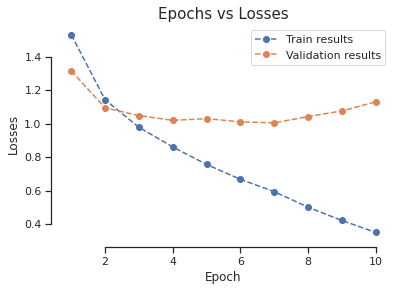

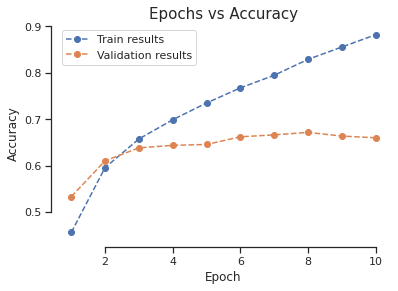

In [11]:
plot("Epochs vs Losses", "Losses", train_losses, val_losses, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)
plot("Epochs vs Accuracy", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)


#### **TODO**
Compare results to MLP. What can you observe?

**Your answers here**

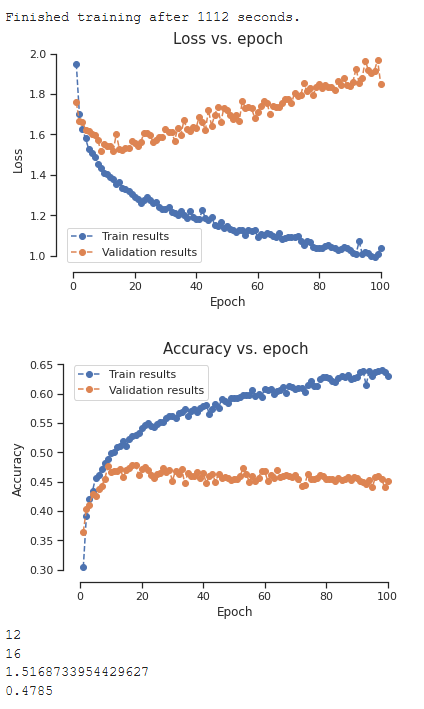

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

In [12]:
# TODO train and plot
train_losses, val_losses, train_accs, val_accs, sp, cm = run_training(model, optimizer, loss_function, device, num_epochs=60,train_dataloader=train_set, val_dataloader=val_set)

Finished training after 711 seconds.


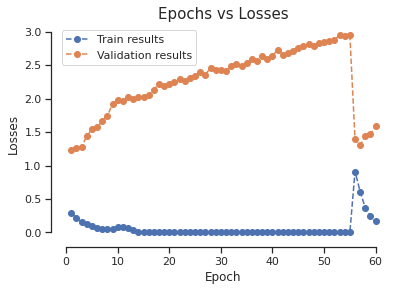

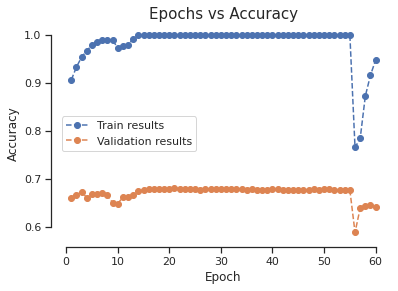

In [13]:
plot("Epochs vs Losses", "Losses", train_losses, val_losses, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)
plot("Epochs vs Accuracy", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)
# The model is not training....


#### **Questions**
- Why is that not an optimal model?
- What could be improved?

**Your answers here**

## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture displayed in the graphic.

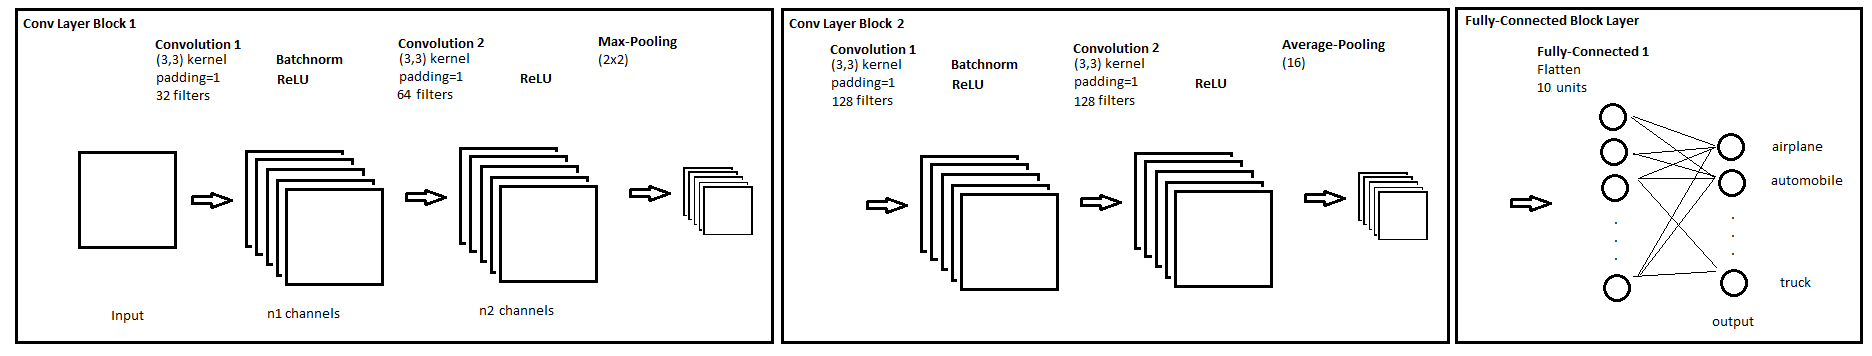

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- What does padding=1 mean in the case of the network displayed above?
- What are the dimensions of the feature maps after the 1. conv layer?
- What are the dimensions of the feature maps after the 2. conv layer?
- What ist the receptive field size after the first two convolutions?
- What is the value for the in_features for the fully-connected layer?
- What is the number of parameters of *Conv Layer block 1*?

**Your answers here**
- Padding means adding pixels on the edges of the input images to prevent size reduction in the output due to the nature of convolution operations. Padding can be zero pading (adding zeros on the outer frame of the image so that the original border is included in the valid convolutions), valid padding (there is not actual padding but the pixels on the edge are considered to be valid for the operation)
- Padding=1 means adding a tuple (1 1) of padding to height or width. That is, adding one row at the beginning and at the end of the matrix of pixels, as well as one column at the beginning and at the end
- Dimensions after conv layer 1: (16 x 16 x 64)
- Dimensions after conv layer 2: (1 x 1 x 128)
- Receptive field size **PENDING**
- The value for the in_features for the fully-connected layer is 128
- Number of parameters after conv layer 1:
 - Convolution 1: 
    - Weights = 3^2 ( kelnel size squared ) * 3 (input channels) * 32 (number of filters) =  864
    - Biases = 32 (number of filters)
    - total = Weights + biases = 864 + 32 = 896
  - Batchnorm: 1 gamma and 1 beta for each channel
    - Total = 2*32 = 64
  - Relu: No parameters
 - Convolution 2: 
    - Weights = 3^2 ( kelnel size squared ) * 32 (input channels) * 64 (number of filters) =  18432
    - Biases = 64 (number of filters)
    - total = Weights + biases = 18432 + 64 = 18496
  -  Max Pool: No parameters
  - **total = (896 + 64 + 18496) = 19456**


In [175]:
#TODO define model 2
class CNN2(nn.Module):
  def __init__(self, img_width, num_in_channels, num_classes):
    
    super(CNN2, self).__init__()
    self.conv= nn.Sequential(
        nn.Conv2d(num_in_channels,32,3, padding=1), 
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,64,3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2), 
        #Here comes the second layer
        nn.Conv2d(64,128,3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128,128,3, padding=1),
        nn.ReLU(),
        nn.AvgPool2d(16),
        nn.Flatten(),
        nn.ReLU(),
        nn.Linear(1*1*128,num_classes)


)
    

  def forward(self,x):
    return self.conv(x)



#### **TODO** 

- train the new net (30 epochs, lr=0.1), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results

In [ ]:
# TODO train and plot
model = CNN2((32*32), 3 , 10)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_function = torch.nn.CrossEntropyLoss()
train_losses, val_losses, train_accs, val_accs, sp, cm = run_training(model, optimizer, loss_function, device, num_epochs=30,train_dataloader=train_set, val_dataloader=val_set)

Finished training after 390 seconds.


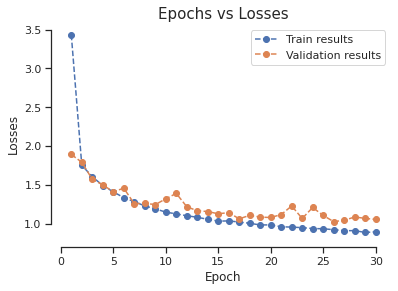

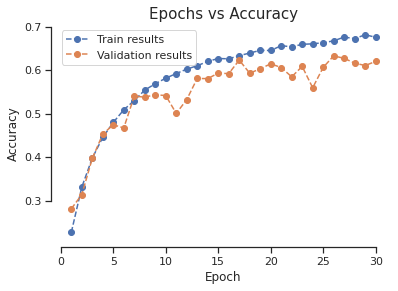

In [ ]:
plot("Epochs vs Losses", "Losses", train_losses, val_losses, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)
plot("Epochs vs Accuracy", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

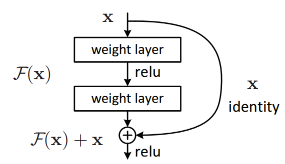

#### **Questions**
- Which problems do using skip connections solve?
- Why is a residual network called residual? 
- When is the advantage of ResNets over 'normal' CNNs most visible?

**Your answers here**

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model
- train the model
- plot results

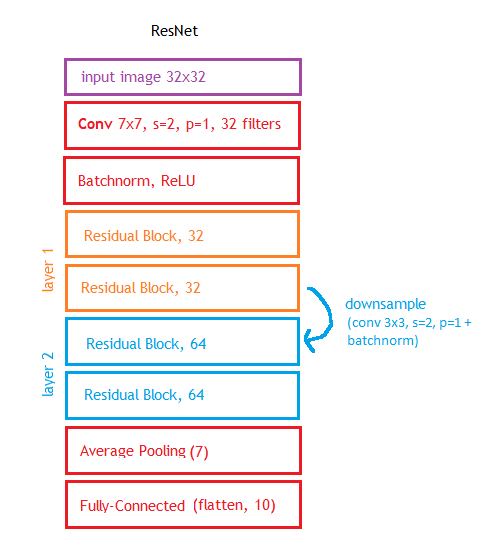 
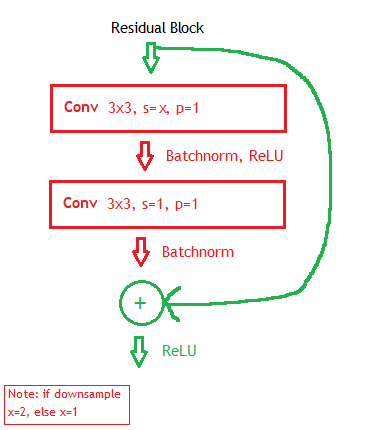

**Hints**

- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).
- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.
- The average-pooling layer has kernel size 7.
- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.
32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [176]:
# TODO write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet
class ResidualBlock(nn.Module):
  def __init__(self, input_ch, intermediate_channels, downsample = None):
    super().__init__()
    self.downsample = downsample
    self.input_ch = input_ch
    if self.downsample is not None:
      self.stride = 2
      self.intermediate_channel = intermediate_channels * 2
      self.conv3 = nn.Conv2d(
                    self.input_ch,
                    self.intermediate_channel,
                    kernel_size=1,
                    stride=self.stride,
                    bias=False)
    else:
      self.stride = 1
      self.intermediate_channel = intermediate_channels
    self.conv1 = nn.Conv2d(input_ch, self.intermediate_channel, kernel_size=3, stride=self.stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(self.intermediate_channel)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(
            self.intermediate_channel,
            self.intermediate_channel,
            kernel_size=3,
            stride= 1,
            padding= 1,
            bias=False)
    self.bn2 = nn.BatchNorm2d(self.intermediate_channel)

  def forward(self, x):
    identity = x.clone()

    x = self.conv1(x)   
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    
    if self.downsample is not None:
      identity = self.conv3(identity)
        #identity = nn.Conv2d(
         #           self.input_ch,
          #          self.intermediate_channel,
           #         kernel_size=1,
            #        stride=self.stride,
             #       bias=False)(identity)
    x = x + identity
    x = self.relu(x)
    return x        

In [177]:
# TODO write a class ResNet(nn.Module) where you define the model
class ResNet(nn.Module):
  def __init__(self, input_dim , image_channels, num_classes):
    super(ResNet, self).__init__()
    self.input_dim = input_dim
    self.conv1 = nn.Conv2d(image_channels, 32, kernel_size=7, stride=2, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(32)
    self.relu = nn.ReLU()
    self.avgpool = nn.AvgPool2d(7)
    self.fc = nn.Linear(64 ,num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = ResidualBlock(x.shape[1], intermediate_channels=32).to(device)(x)
    x = ResidualBlock(x.shape[1], intermediate_channels=32,downsample = True).to(device)(x)
    x = ResidualBlock(x.shape[1], intermediate_channels=64).to(device)(x)
    x = ResidualBlock(x.shape[1], intermediate_channels=64).to(device)(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)
    return x

In [178]:
# TODO train and plot
model = ResNet((32*32), 3 , 10)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()
train_losses, val_losses, train_accs, val_accs, sp, cm = run_training(model, optimizer, loss_function, device, num_epochs=10,train_dataloader=train_set, val_dataloader=val_set)

Finished training after 134 seconds.


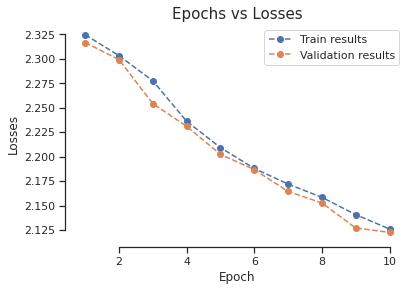

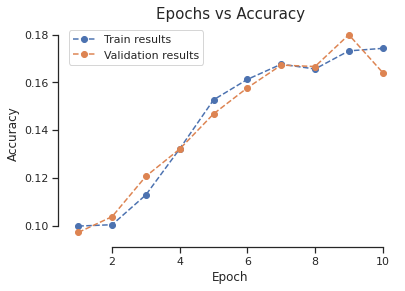

In [179]:
plot("Epochs vs Losses", "Losses", train_losses, val_losses, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)
plot("Epochs vs Accuracy", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)


In [156]:
for x, y in train_set:
  x = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=1, bias=False)(x)
  x = nn.BatchNorm2d(32)(x)
  x = nn.ReLU()(x)
  i = x.clone()
  i = nn.Conv2d(32,
                    64,
                    kernel_size=1,
                    stride=2,
                    bias=False)(i)
  x = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)(x)
  x = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False)(x)
  x = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)(x)
  x= x+i
  break

#### **Questions**
- Does the performance increase compared to the CNNs you trained before? Why/Why not?
- Compare the runtime of CNN and ResNet.

**Your answers here**

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*torch.optim.lr_scheduler* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

In [193]:
# TODO change run_training (you can copy the code from utils.py here and create a new method here 
# or just change/create a new method it in the python file)
def run_training_lr(model, optimizer, loss_function,scheduler, device, num_epochs, 
                train_dataloader, val_dataloader, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        scheduler: Learning rate Scheduler
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]
    stopping_pts = ()
    
    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = utils.train(train_dataloader, optimizer, model,loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = utils.validate(val_dataloader,model, loss_function,device, master_bar)
        # Learning rate scheduling
       # scheduler.step(epoch_val_loss)
        scheduler.step()

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:          
          early_stopper.stopping_criterion(epoch_val_acc)
          
          if early_stopper.early_stop:
            print('Epoch :', str(epoch))   
            stopping_pts = (val_accs.index(max(val_accs))+1,max(val_accs))    
            #model.load_state_dict(torch.load('checkpoint.pt'))                 
            break
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, stopping_pts,confusion_matrix


In [181]:
# TODO train and plot with step size 1, gamma 0.1

# LR = 0.1 for epoch =1
# LR = 0.01(0.1* 0.1(gamma)) for epoch = 2
# LR = 0.001(0.01*0.1) for epoch = 3 and soon....

model = ResNet(32,3,10).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_function = torch.nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

train_losses, val_losses, train_accs, val_accs, sp, cm = run_training_lr(model, optimizer, loss_function, scheduler,device, num_epochs=10, 
                train_dataloader=train_set, val_dataloader=val_set)

Finished training after 136 seconds.


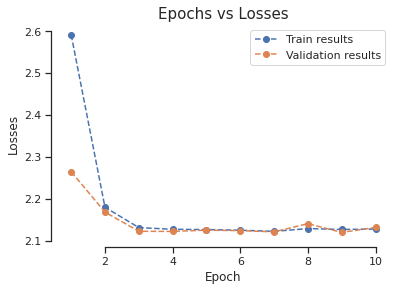

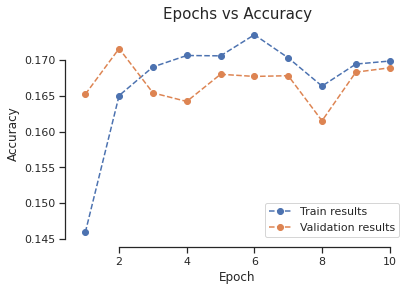

In [182]:
plot("Epochs vs Losses", "Losses", train_losses, val_losses, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)
plot("Epochs vs Accuracy", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)


In [183]:
# TODO train and plot with step size 1, gamma 0.9

# LR = 0.9 for epoch =1
# LR = 0.09(0.9* 0.9(gamma)) for epoch = 2
# LR = 0.009(0.09*0.9) for epoch = 3 and soon....

model = ResNet(32,3,10).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_function = torch.nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

train_losses, val_losses, train_accs, val_accs, sp, cm = run_training_lr(model, optimizer, loss_function, scheduler,device, num_epochs=10, 
                train_dataloader=train_set, val_dataloader=val_set)

Finished training after 146 seconds.


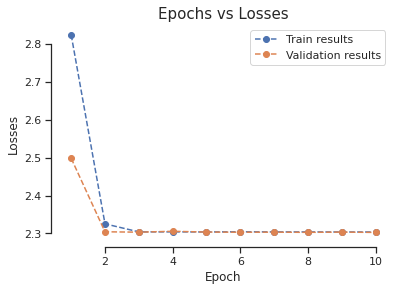

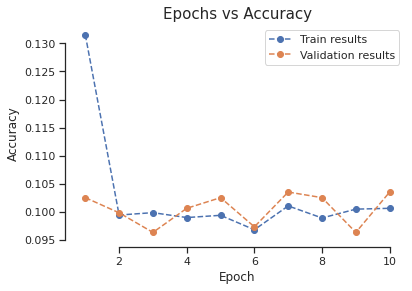

In [168]:
plot("Epochs vs Losses", "Losses", train_losses, val_losses, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)
plot("Epochs vs Accuracy", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)


#### **TODO** 

Use the learning rate schedule as described in the ResNet paper (https://arxiv.org/pdf/1512.03385.pdf). Train for 30 epochs.

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**Your answers here**

In [ ]:
# TODO train and plot with scheduling, optimizer, lr as in the paper.

## [7. Optional LR-Scheduling]

Note: this part of the exercise is optional and you will get additional points for solving it. They do not count into the denominator when calculating the 50% threshold for qualifying for the exam.

#### **TODO**
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler? NO
- does it improve performance compared to StepLR? NO

**Your answers here**

In [184]:
# TODO train and plot
# ExponentialLR -> gamma = 0.1
model = ResNet(32,3,10).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_function = torch.nn.CrossEntropyLoss()
scheduler = ExponentialLR(optimizer, gamma=0.1)

train_losses, val_losses, train_accs, val_accs, sp, cm = run_training_lr(model, optimizer, loss_function, scheduler,device, num_epochs=10, 
                train_dataloader=train_set, val_dataloader=val_set)


Finished training after 140 seconds.


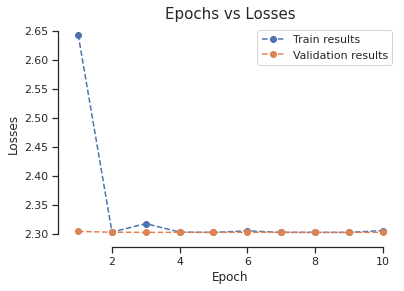

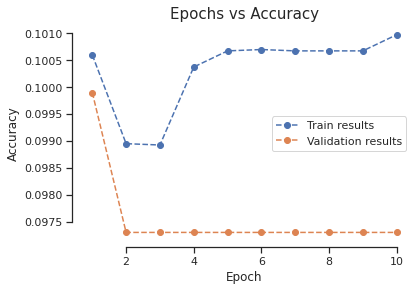

In [185]:
plot("Epochs vs Losses", "Losses", train_losses, val_losses, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)
plot("Epochs vs Accuracy", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None) 

Finished training after 136 seconds.


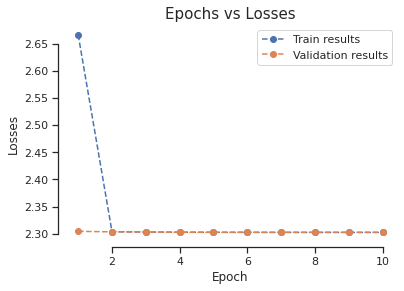

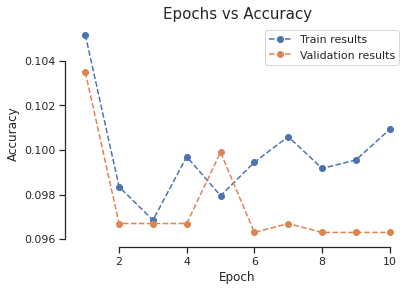

In [194]:
# ExponentialLR -> gamma = 0.5
model = ResNet(32,3,10).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_function = torch.nn.CrossEntropyLoss()
scheduler = ExponentialLR(optimizer, gamma=0.5)

train_losses, val_losses, train_accs, val_accs, sp, cm = run_training_lr(model, optimizer, loss_function, scheduler,device, num_epochs=10, 
                train_dataloader=train_set, val_dataloader=val_set)

plot("Epochs vs Losses", "Losses", train_losses, val_losses, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)
plot("Epochs vs Accuracy", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)

Finished training after 141 seconds.


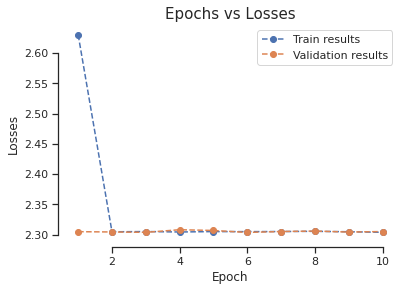

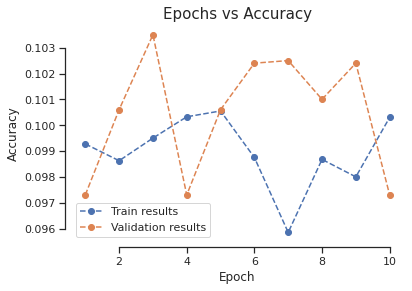

In [186]:
# ExponentialLR -> gamma = 0.9
model = ResNet(32,3,10).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_function = torch.nn.CrossEntropyLoss()
scheduler = ExponentialLR(optimizer, gamma=0.9)

train_losses, val_losses, train_accs, val_accs, sp, cm = run_training_lr(model, optimizer, loss_function, scheduler,device, num_epochs=10, 
                train_dataloader=train_set, val_dataloader=val_set)

plot("Epochs vs Losses", "Losses", train_losses, val_losses, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)
plot("Epochs vs Accuracy", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)

Finished training after 137 seconds.


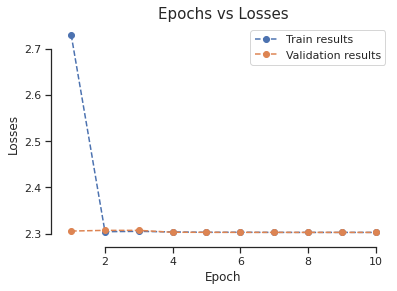

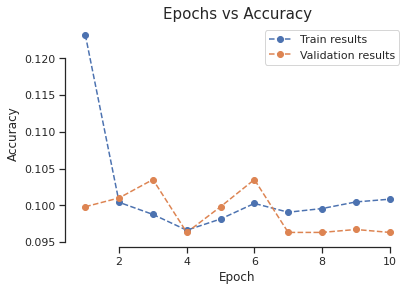

In [191]:
# ReduceLROnPlateau -> gamma = 0.1
model = ResNet(32,3,10).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_function = torch.nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer,factor=0.1)

train_losses, val_losses, train_accs, val_accs, sp, cm = run_training_lr(model, optimizer, loss_function, scheduler,device, num_epochs=10,train_dataloader=train_set, val_dataloader=val_set)

plot("Epochs vs Losses", "Losses", train_losses, val_losses, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)
plot("Epochs vs Accuracy", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)

Finished training after 137 seconds.


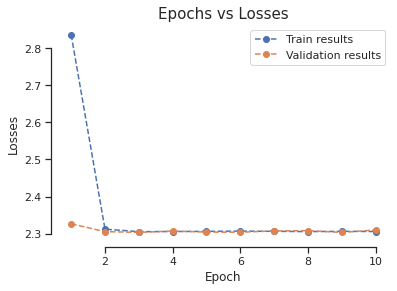

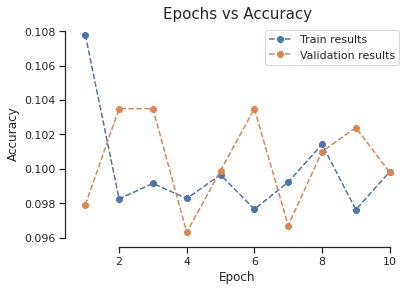

In [192]:
# ReduceLROnPlateau -> gamma = 0.9
model = ResNet(32,3,10).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_function = torch.nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, factor=0.9)

train_losses, val_losses, train_accs, val_accs, sp, cm = run_training_lr(model, optimizer, loss_function, scheduler,device, num_epochs=10, 
                train_dataloader=train_set, val_dataloader=val_set)

plot("Epochs vs Losses", "Losses", train_losses, val_losses, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)
plot("Epochs vs Accuracy", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)

## [8. Optional Transfer Learning]


Note: this part of the exercise is optional and you will get additional points for solving it. They do not count into the denominator when calculating the 50% threshold for qualifying for the exam.

### **TODO**

- load a pretrained ResNet from torchvision
- freeze the parameters so that the gradients are not computed
- replace the last fully-connected layer
- fine-tune the model
- plot the results again and compare to approaches before
    - is a better performance reached? why/why not?
    - does it take more/less time to fine-tune compared to train a resnet?

**Your answers here**

In [ ]:
# TODO do transfer learning with resnet on cifar10

model_resnet = models.resnet50(pretrained = True)

for param in model_resnet.parameters():
  param.requires_grad = False

num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, 10)

model_resnet.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_function = torch.nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

train_losses, val_losses, train_accs, val_accs, sp, cm = run_training_lr(model_resnet, optimizer, loss_function, scheduler,device, num_epochs=10, 
                train_dataloader=train_set, val_dataloader=val_set)


Finished training after 136 seconds.


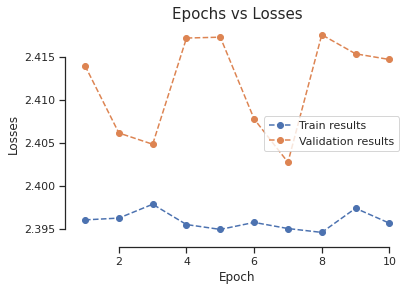

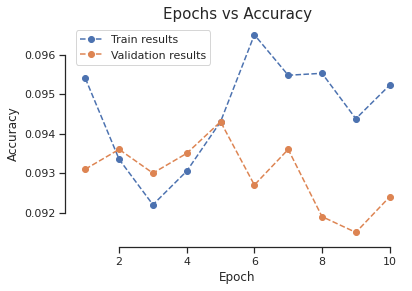

In [ ]:
plot("Epochs vs Losses", "Losses", train_losses, val_losses, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)
plot("Epochs vs Accuracy", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None)
